In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import hiplot as hip
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed",
    "Avg packet len", "Source IP count", "Time"
]

# Events
event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code",
    "Detect count", "Significant flag", "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Start time", "End time", "Whitelist flag", "Type"
]

df_A_components = pd.read_csv("../datasets/SCLDDoS2024_SetA_components.csv")
df_A_events = pd.read_csv("../datasets/SCLDDoS2024_SetA_events.csv")

df_D_components = pd.read_csv("../datasets/SCLDDoS2024_SetD_components.csv")
df_D_events = pd.read_csv("../datasets/SCLDDoS2024_SetD_events.csv")

df_B_components = pd.read_csv("../datasets/SCLDDoS2024_SetB_components.csv", header=None, names=component_columns)
df_B_events = pd.read_csv("../datasets/SCLDDoS2024_SetB_events.csv", header=None, names=event_columns)

df_C_components = pd.read_csv("../datasets/SCLDDoS2024_SetC_components.csv", header=None, names=component_columns)
df_C_events = pd.read_csv("../datasets/SCLDDoS2024_SetC_events.csv", header=None, names=event_columns)

In [3]:
df_A_events = df_A_events.drop(df_A_events[df_A_events['End time']=="0"].index)
df_B_events = df_B_events.drop(df_B_events[df_B_events['End time']=="0"].index)
df_C_events = df_C_events.drop(df_C_events[df_C_events['End time']=="0"].index)
df_D_events = df_D_events.drop(df_D_events[df_D_events['End time']=="0"].index)

In [4]:
df_A_events['Avg packet len'] = df_A_events['Avg packet len'].replace(0, 1)
df_B_events['Avg packet len'] = df_B_events['Avg packet len'].replace(0, 1)
df_C_events['Avg packet len'] = df_C_events['Avg packet len'].replace(0, 1)
df_D_events['Avg packet len'] = df_D_events['Avg packet len'].replace(0, 1)

In [5]:
df_A_events['Start time']=pd.to_datetime(df_A_events['Start time'])
df_A_events['End time']=pd.to_datetime(df_A_events['End time'])
df_A_components['Time']=pd.to_datetime(df_A_components['Time'])
df_B_events['Start time']=pd.to_datetime(df_B_events['Start time'])
df_B_events['End time']=pd.to_datetime(df_B_events['End time'])
df_B_components['Time']=pd.to_datetime(df_B_components['Time'])
df_C_events['Start time']=pd.to_datetime(df_C_events['Start time'])
df_C_events['End time']=pd.to_datetime(df_C_events['End time'])
df_C_components['Time']=pd.to_datetime(df_C_components['Time'])
df_D_events['Start time']=pd.to_datetime(df_D_events['Start time'])
df_D_events['End time']=pd.to_datetime(df_D_events['End time'])
df_D_components['Time']=pd.to_datetime(df_D_components['Time'])

In [6]:
df_A_events = df_A_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_A_components = df_A_components.drop(columns=['Significant flag'])
df_B_events = df_B_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_B_components = df_B_components.drop(columns=['Significant flag'])
df_C_events = df_C_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_C_components = df_C_components.drop(columns=['Significant flag'])
df_D_events = df_D_events.drop(columns=['Significant flag', 'Whitelist flag'])
df_D_components = df_D_components.drop(columns=['Significant flag'])

In [7]:
df_A_events = df_A_events.drop(columns=['Card'])
df_B_events = df_B_events.drop(columns=['Card'])
df_C_events = df_C_events.drop(columns=['Card'])
df_D_events = df_D_events.drop(columns=['Card'])

In [8]:
df_A_events['Duration']=(df_A_events['End time'] - df_A_events['Start time']).dt.total_seconds()
df_B_events['Duration']=(df_B_events['End time'] - df_B_events['Start time']).dt.total_seconds()
df_C_events['Duration']=(df_C_events['End time'] - df_C_events['Start time']).dt.total_seconds()
df_D_events['Duration']=(df_D_events['End time'] - df_D_events['Start time']).dt.total_seconds()

In [9]:
train_df = pd.concat([df_A_events, df_B_events])
val_df = df_C_events
features = [
    "Port number",
    "Detect count",  "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Duration"
]

In [10]:
X_train = train_df[features]
X_test = val_df[features]
y_train = train_df["Type"]
y_test = val_df["Type"]

In [11]:
csvs = [df_A_events, df_B_events, df_C_events, df_D_events]

In [12]:
for df in csvs:
    #TIME FEATURES
    df['Start time'] = pd.to_datetime(df['Start time'])
    df['End time'] = pd.to_datetime(df['End time'])
    df['Hour'] = df['Start time'].dt.hour
    df['Hour sin'] = np.sin(df['Hour'] * (2. * np.pi / 24))
    df['Hour cos'] = np.cos(df['Hour'] * (2. * np.pi / 24))
    df['Day of Week'] = df['Start time'].dt.dayofweek
    df['Duration'] = (df['End time'] - df['Start time']).dt.total_seconds()
    #events under 1 second would be 0 duration, so we set them to 0.5
    df.loc[df['Duration'] == 0, 'Duration'] = 0.5

    #DERIVED FEATURES
    df['Packet Rate'] = df['Packet speed'] / df['Duration']
    df['Data Rate'] = df['Data speed'] / df['Duration']
    df['Packet Size to Speed Ratio'] = df['Avg packet len'] / df['Packet speed']
    df['Data to Packet Ratio'] = df['Data speed'] / df['Packet speed']  

features = [
    "Port number",
    "Detect count",  "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Duration",
    'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
    'Hour sin', 'Hour cos', 'Day of Week'
]
train_df = pd.concat([df_A_events, df_B_events])
val_df = df_C_events

In [13]:
comp_csvs = [df_A_components, df_B_components, df_C_components, df_D_components]
for df, df_comp in zip(csvs, comp_csvs):
    unique_ports = df_comp.groupby('Attack ID')['Port number'].nunique()
    df['Unique ports']=df_comp['Attack ID'].map(unique_ports)
    
    std_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].std(ddof=0)
    df['Std packet speed']=df_comp['Attack ID'].map(std_packet_speed)
    max_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].max()
    df['Max packet speed']=df_comp['Attack ID'].map(max_packet_speed)
    
    std_data_speed = df_comp.groupby('Attack ID')['Data speed'].std(ddof=0)
    df['Std data speed']=df_comp['Attack ID'].map(std_data_speed)
    max_data_speed = df_comp.groupby('Attack ID')['Data speed'].max()
    df['Max data speed']=df_comp['Attack ID'].map(max_data_speed)
    
    std_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].std(ddof=0)
    df['Std packet length']=df_comp['Attack ID'].map(std_packet_length)
    max_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].max()
    df['Max packet length']=df_comp['Attack ID'].map(max_packet_length)

    std_source_ip_count= df_comp.groupby('Attack ID')['Source IP count'].std(ddof=0)
    df['Std source IP count']=df_comp['Attack ID'].map(std_source_ip_count)
    max_source_ip_count = df_comp.groupby('Attack ID')['Source IP count'].max()
    df['Max source IP count']=df_comp['Attack ID'].map(max_source_ip_count)

    df_comp['Time']=pd.to_datetime(df_comp['Time'])
    df_comp = df_comp.sort_values(by=["Attack ID", "Time"])
    df_comp["Time diff"] = df_comp.groupby("Attack ID")["Time"].diff().dt.total_seconds().fillna(0)
    time_diff_mean = df_comp.groupby("Attack ID")["Time diff"].mean()
    time_diff_std = df_comp.groupby("Attack ID")["Time diff"].std(ddof=0)
    df['Mean time diff'] = df_comp['Attack ID'].map(time_diff_mean)
    df['Std time diff'] = df_comp['Attack ID'].map(time_diff_std)

In [14]:
features = [
    "Port number",
    "Detect count",  "Packet speed", "Data speed",
    "Avg packet len", "Avg source IP count", "Duration",
    'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
    'Hour sin', 'Hour cos', 'Day of Week',
]
train_df = pd.concat([df_A_events, df_B_events])
val_df = df_C_events

In [15]:
X_train = train_df[features]
X_test = val_df[features]
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9913615384615385
Precision: 0.8898144371490938
Recall: 0.7980815372397122


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import optuna

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)

    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    precision = precision_score(y_test_data, y_pred, average="macro")
    f1 = f1_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)

    # Print results
    print(f"{model_name} with {data_type}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Store results
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }

    return model, y_pred, conf_matrix
    

def plot_conf_matrix(cm, model_name, data_type, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - {data_type}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

In [19]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train, X_test, y_test,
    "CatBoost", "original data"
)

CatBoost with original data
Accuracy: 0.9915, Recall: 0.8129, Precision: 0.8899, F1-score: 0.8421
Confusion Matrix:
[[   534    495     26]
 [   104 125512    277]
 [    55    142   2855]]


In [20]:
ada_model = AdaBoostClassifier(random_state=42)
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train, X_test, y_test,
    "AdaBoost", "original data"
)

AdaBoost with original data
Accuracy: 0.9838, Recall: 0.6133, Precision: 0.8674, F1-score: 0.6777
Confusion Matrix:
[[   172    853     30]
 [    52 125655    186]
 [    18    962   2072]]


In [21]:
def optimize_catboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing CatBoost ===")
    
    def objective(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
            'random_seed': 42
        }
        
        model = CatBoostClassifier(**param, verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best CatBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['verbose'] = 0
    best_params['random_seed'] = 42
    
    return CatBoostClassifier(**best_params)

# Optimize AdaBoost with Optuna
def optimize_adaboost(X_train, y_train, X_val, y_val):
    print("\n=== Optimizing AdaBoost ===")
    
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'algorithm': 'SAMME', 
            'random_state': 42
        }
        
        model = AdaBoostClassifier(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        return f1
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    
    print("Best AdaBoost parameters:", study.best_params)
    best_params = study.best_params
    best_params['algorithm'] = 'SAMME'  # Ensure this is set
    best_params['random_state'] = 42
    
    return AdaBoostClassifier(**best_params)

# Optimize models
best_catboost = optimize_catboost(X_train, y_train, X_test, y_test)
best_adaboost = optimize_adaboost(X_train, y_train, X_test, y_test)

# Evaluate optimized models
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test, y_test,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test, y_test,
    "AdaBoost (optimized)", "selected features"
)

[I 2025-05-13 04:23:17,004] A new study created in memory with name: no-name-c71c0c16-a3b7-4f88-aa0e-60d0c1f1bdf3



=== Optimizing CatBoost ===


[I 2025-05-13 04:23:20,090] Trial 0 finished with value: 0.7517676754326633 and parameters: {'iterations': 238, 'learning_rate': 0.08358924360040518, 'depth': 4, 'l2_leaf_reg': 7.058521498102485, 'border_count': 86, 'random_strength': 9.30352994608907, 'bagging_temperature': 8.541288525733208}. Best is trial 0 with value: 0.7517676754326633.
[I 2025-05-13 04:23:43,981] Trial 1 finished with value: 0.8181422903560781 and parameters: {'iterations': 661, 'learning_rate': 0.21492024202358712, 'depth': 8, 'l2_leaf_reg': 3.904888198467166, 'border_count': 145, 'random_strength': 9.649083848725178, 'bagging_temperature': 5.3262540617791885}. Best is trial 1 with value: 0.8181422903560781.
[I 2025-05-13 04:23:54,387] Trial 2 finished with value: 0.7734719652597745 and parameters: {'iterations': 877, 'learning_rate': 0.028951191469061603, 'depth': 4, 'l2_leaf_reg': 5.064627600703498, 'border_count': 96, 'random_strength': 4.375978895381612, 'bagging_temperature': 5.123526140135221}. Best is tri

Best CatBoost parameters: {'iterations': 220, 'learning_rate': 0.25694464934240324, 'depth': 5, 'l2_leaf_reg': 9.140778603770757, 'border_count': 255, 'random_strength': 5.462981505564705, 'bagging_temperature': 0.036264138786484434}

=== Optimizing AdaBoost ===


[I 2025-05-13 04:27:53,742] Trial 0 finished with value: 0.7582925270287353 and parameters: {'n_estimators': 289, 'learning_rate': 0.7290031378712735}. Best is trial 0 with value: 0.7582925270287353.
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
[I 2025-05-13 04:29:50,441] Trial 1 finished with value: 0.6552057056369104 and parameters: {'n_estimators': 340, 'learning_rate': 0.14771390964524755}. Best is trial 0 with value: 0.7582925270287353.
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
[I 2025-05-13 04:31:30,641] Trial 2 finished with value: 0.7522057575592895 and parameters: {'n_estimators': 324, 'learning_rate': 0.6994731491223956}. Best is trial 0 w

Best AdaBoost parameters: {'n_estimators': 289, 'learning_rate': 0.7290031378712735}
CatBoost (optimized) with selected features
Accuracy: 0.9914, Recall: 0.8138, Precision: 0.8951, F1-score: 0.8436
Confusion Matrix:
[[   534    496     25]
 [   101 125484    308]
 [    37    151   2864]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9855, Recall: 0.6842, Precision: 0.8986, F1-score: 0.7583
Confusion Matrix:
[[   378    655     22]
 [    72 125612    209]
 [    19    907   2126]]


In [22]:
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test, y_test,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test, y_test,
    "AdaBoost (optimized)", "selected features"
)

CatBoost (optimized) with selected features
Accuracy: 0.9914, Recall: 0.8138, Precision: 0.8951, F1-score: 0.8436
Confusion Matrix:
[[   534    496     25]
 [   101 125484    308]
 [    37    151   2864]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9855, Recall: 0.6842, Precision: 0.8986, F1-score: 0.7583
Confusion Matrix:
[[   378    655     22]
 [    72 125612    209]
 [    19    907   2126]]


In [23]:
# Method 1: Simple Voting Classifier
def create_voting_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Voting Ensemble ===")
    le= LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    # Train models on respective selected features
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Get predictions for both models
    cat_preds = best_catboost.predict_proba(X_test_cat)
    ada_preds = best_adaboost.predict_proba(X_test_ada)
    
    # Combine predictions (weighted average)
    # Adjust these weights based on model performance
    ensemble_preds = cat_preds * 0.7 + ada_preds * 0.3
    ensemble_classes = np.argmax(ensemble_preds, axis=1)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Voting Ensemble (weighted probabilities)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Voting Ensemble (weighted)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix

# Method 2: Stacking Ensemble with XGBoost as meta-learner
def create_stacking_ensemble(X_train_cat, X_train_ada, X_test_cat, X_test_ada, y_train, y_test):
    print("\n=== Creating Stacking Ensemble ===")
    le= LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    # Train base models
    best_catboost.fit(X_train_cat, y_train)
    best_adaboost.fit(X_train_ada, y_train)
    
    # Generate meta-features
    cat_train_preds = best_catboost.predict_proba(X_train_cat)
    ada_train_preds = best_adaboost.predict_proba(X_train_ada)
    
    # Combine meta-features
    meta_features_train = np.hstack([cat_train_preds, ada_train_preds])
    
    # Train meta-learner
    meta_learner = XGBClassifier(random_state=42)
    meta_learner.fit(meta_features_train, y_train)
    
    # Generate meta-features for test set
    cat_test_preds = best_catboost.predict_proba(X_test_cat)
    ada_test_preds = best_adaboost.predict_proba(X_test_ada)
    meta_features_test = np.hstack([cat_test_preds, ada_test_preds])
    
    # Make final predictions
    ensemble_classes = meta_learner.predict(meta_features_test)
    
    # Evaluate ensemble
    accuracy = accuracy_score(y_test, ensemble_classes)
    recall = recall_score(y_test, ensemble_classes, average="macro")
    precision = precision_score(y_test, ensemble_classes, average="macro")
    f1 = f1_score(y_test, ensemble_classes, average="macro")
    conf_matrix = confusion_matrix(y_test, ensemble_classes)
    
    print("Stacking Ensemble (XGBoost meta-learner)")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Store results
    results["Stacking Ensemble (XGBoost)"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }
    
    return ensemble_classes, conf_matrix, meta_learner

# Create ensemble models
voting_preds, voting_conf = create_voting_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)

stacking_preds, stacking_conf, meta_learner = create_stacking_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)



=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9915, Recall: 0.8138, Precision: 0.8971, F1-score: 0.8443
Confusion Matrix:
[[   534    497     24]
 [    97 125491    305]
 [    37    151   2864]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.9901, Recall: 0.8223, Precision: 0.8501, F1-score: 0.8325
Confusion Matrix:
[[   560    470     25]
 [   208 125280    405]
 [    49    131   2872]]


In [24]:
rf = RandomForestClassifier()
randomforest, y_pred_rf, conf_rf = evaluate_model(
    rf, X_train, y_train, X_test, y_test,
    "Random forest", "selected features"
)

Random forest with selected features
Accuracy: 0.9912, Recall: 0.7989, Precision: 0.8772, F1-score: 0.8322
Confusion Matrix:
[[   531    505     19]
 [   105 125596    192]
 [   113    205   2734]]


In [50]:
X_train = train_df[features]
X_test = val_df[features]
y_train = train_df["Type"]
y_test = val_df["Type"]
catboost_result, y_pred_cat, conf_cat_1 = evaluate_model(
    catboost_model, X_train, y_train, X_test, y_test,
    "CatBoost", "original data"
)
ada_result, y_pred_ada, conf_ada_1 = evaluate_model(
    ada_model, X_train, y_train, X_test, y_test,
    "AdaBoost", "original data"
)
catboost_optimized, y_pred_cat_opt, conf_cat_opt_1 = evaluate_model(
    best_catboost, X_train, y_train, X_test, y_test,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt_1 = evaluate_model(
    best_adaboost, X_train, y_train, X_test, y_test,
    "AdaBoost (optimized)", "selected features"
)
randomforest, y_pred_rf, conf_rf_1 = evaluate_model(
    rf, X_train, y_train, X_test, y_test,
    "Random forest", "selected features"
)
voting_preds, voting_conf_1 = create_voting_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)

stacking_preds, stacking_conf_1, meta_learner = create_stacking_ensemble(
    X_train, X_train,
    X_test, X_test,
    y_train, y_test
)

CatBoost with original data
Accuracy: 0.9915, Recall: 0.8129, Precision: 0.8899, F1-score: 0.8421
Confusion Matrix:
[[   534    495     26]
 [   104 125512    277]
 [    55    142   2855]]
AdaBoost with original data
Accuracy: 0.9838, Recall: 0.6133, Precision: 0.8674, F1-score: 0.6777
Confusion Matrix:
[[   172    853     30]
 [    52 125655    186]
 [    18    962   2072]]
CatBoost (optimized) with selected features
Accuracy: 0.9914, Recall: 0.8138, Precision: 0.8951, F1-score: 0.8436
Confusion Matrix:
[[   534    496     25]
 [   101 125484    308]
 [    37    151   2864]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9855, Recall: 0.6842, Precision: 0.8986, F1-score: 0.7583
Confusion Matrix:
[[   378    655     22]
 [    72 125612    209]
 [    19    907   2126]]
Random forest with selected features
Accuracy: 0.9914, Recall: 0.8007, Precision: 0.8824, F1-score: 0.8343
Confusion Matrix:
[[   527    505     23]
 [    88 125593    212]
 [   106    184   2762]]

=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9915, Recall: 0.8138, Precision: 0.8971, F1-score: 0.8443
Confusion Matrix:
[[   534    497     24]
 [    97 125491    305]
 [    37    151   2864]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.9901, Recall: 0.8223, Precision: 0.8501, F1-score: 0.8325
Confusion Matrix:
[[   560    470     25]
 [   208 125280    405]
 [    49    131   2872]]



=== Final Comparison ===
                                          Accuracy  Recall  Precision  \
CatBoost (original data)                     99.15   81.29      88.99   
AdaBoost (original data)                     98.38   61.33      86.74   
CatBoost (optimized) (selected features)     99.14   81.38      89.51   
AdaBoost (optimized) (selected features)     98.55   68.42      89.86   
Voting Ensemble (weighted)                   99.15   81.38      89.71   
Stacking Ensemble (XGBoost)                  99.01   82.23      85.01   
Random forest (selected features)            99.14   80.07      88.24   

                                          F1-score  
CatBoost (original data)                     84.21  
AdaBoost (original data)                     67.77  
CatBoost (optimized) (selected features)     84.36  
AdaBoost (optimized) (selected features)     75.83  
Voting Ensemble (weighted)                   84.43  
Stacking Ensemble (XGBoost)                  83.25  
Random forest (sel

<Figure size 1200x800 with 0 Axes>

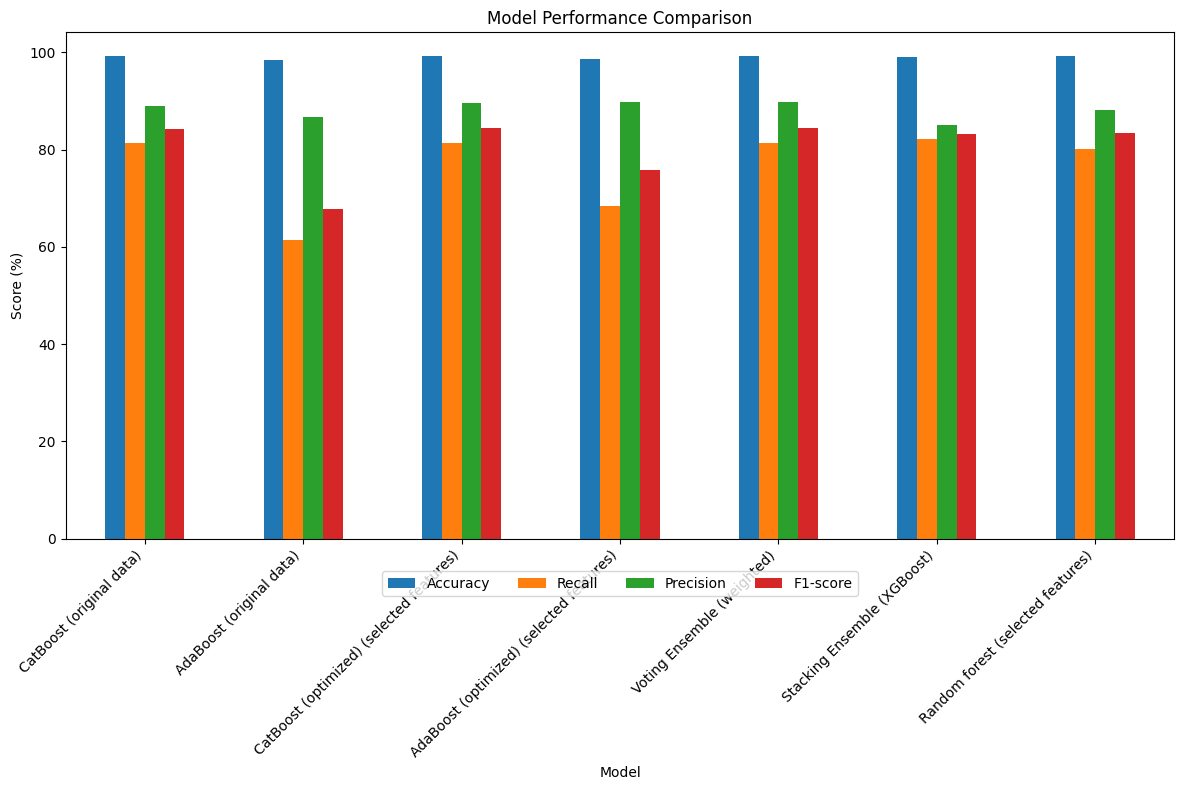

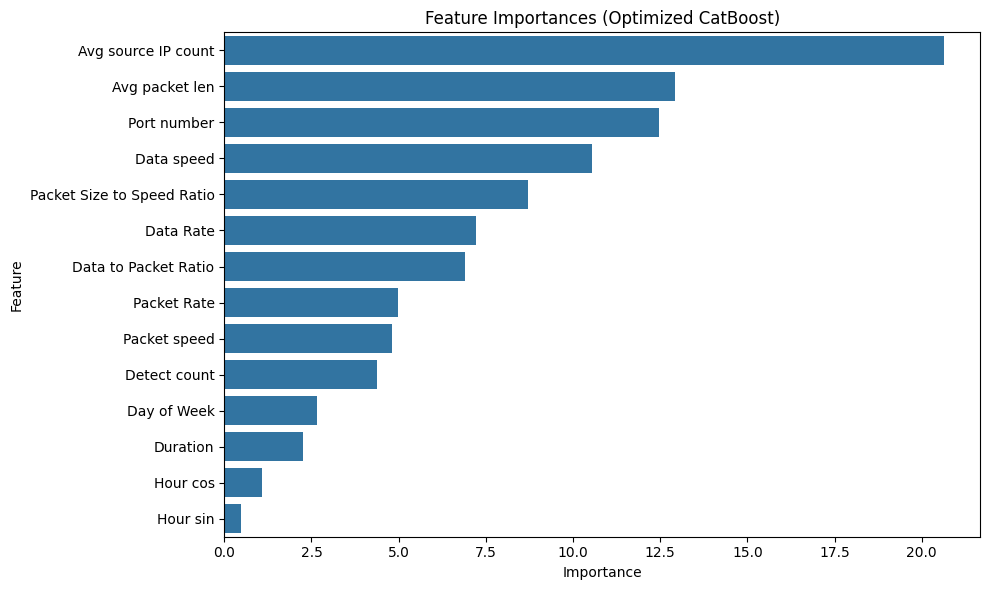


Best models saved to disk.

Completed feature selection, model optimization, and ensemble creation.


In [51]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Final Comparison ===")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig('model_comparison_1.png')
plt.show()

# Get feature importance from the best model (CatBoost)
catboost_optimized.fit(X_train, y_train)
feature_importances = catboost_optimized.get_feature_importance()
feature_names = X_train.columns

# Create and plot feature importance DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Optimized CatBoost)')
plt.tight_layout()
plt.savefig('feature_importance_1.png')
plt.show()

# Save the best models
import joblib
joblib.dump(best_catboost, 'best_catboost_model.pkl')
joblib.dump(best_adaboost, 'best_adaboost_model.pkl')
joblib.dump(meta_learner, 'stacking_meta_learner.pkl')

print("\nBest models saved to disk.")
print("\nCompleted feature selection, model optimization, and ensemble creation.")

# Return the final selected features for documentation
# print("\nFinal selected features for CatBoost:")
# print(catboost_selected_features)
# print("\nFinal selected features for RFECV:")
# print(rfecv_selected_features)

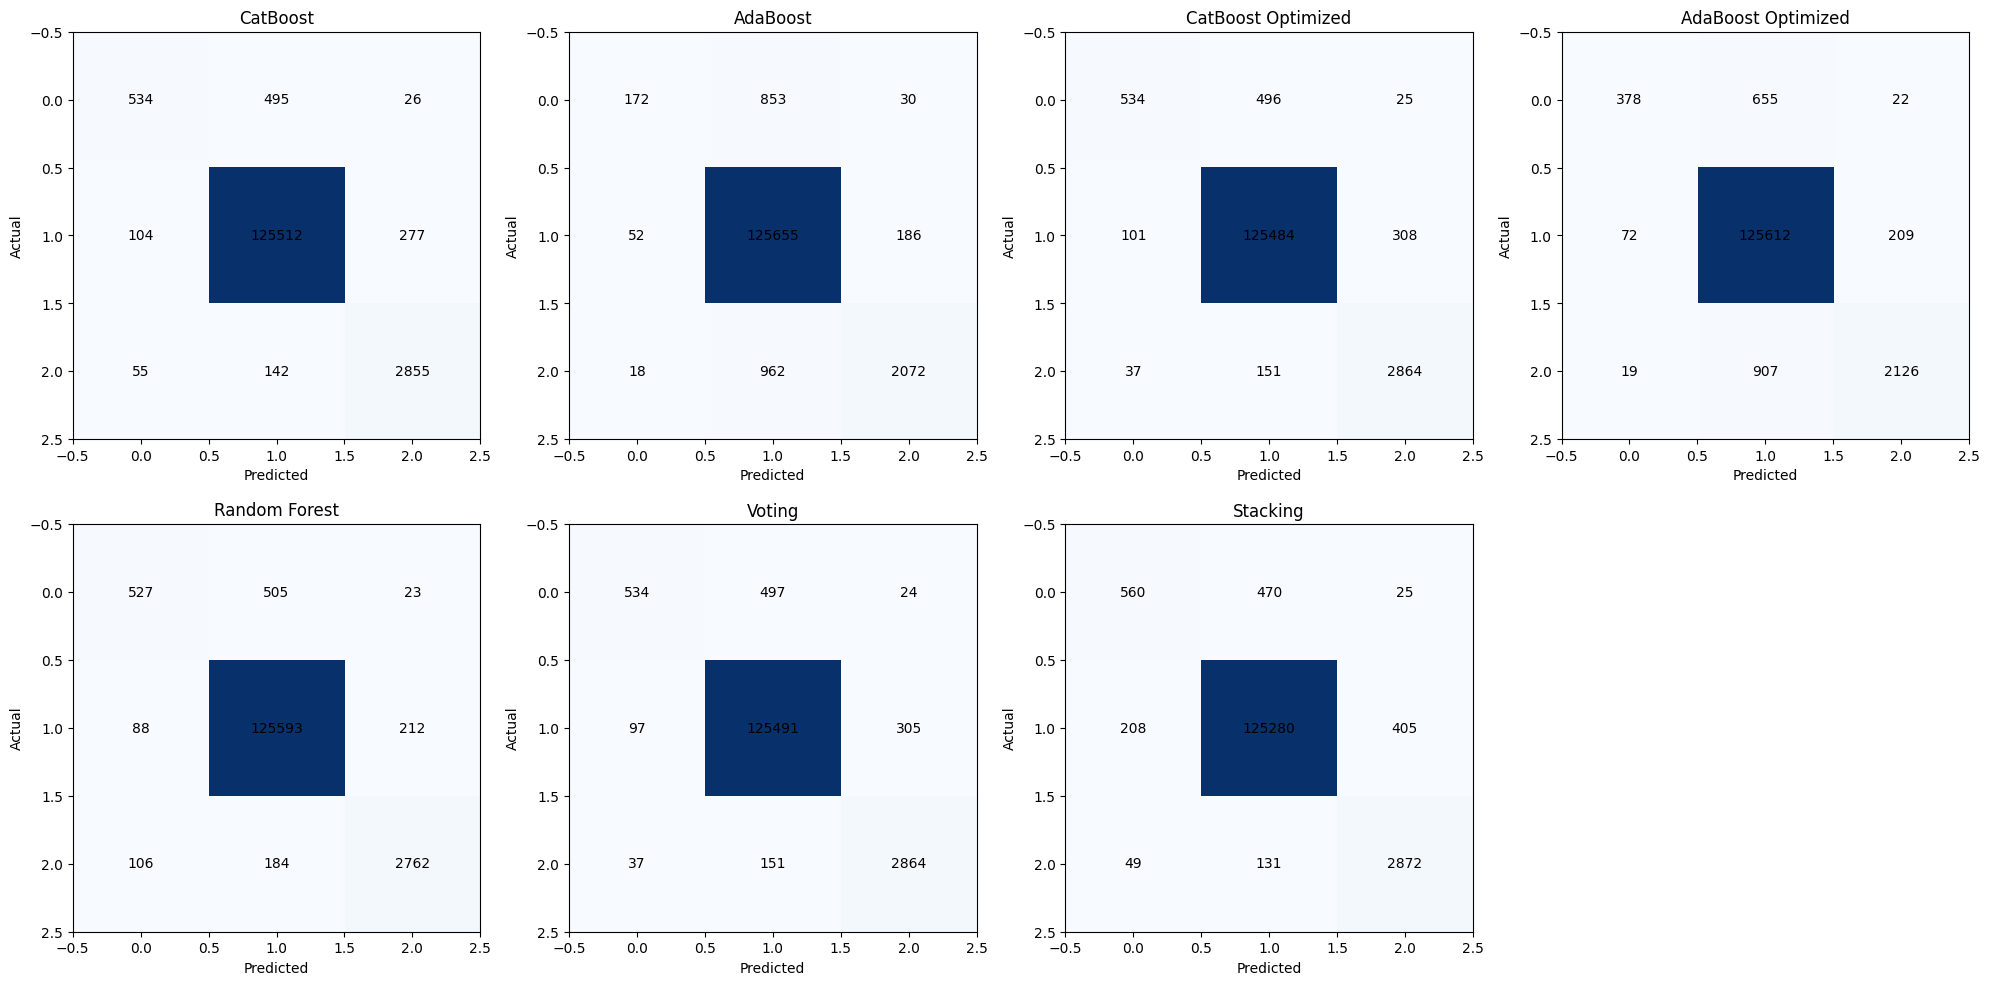

In [54]:
matrices = [
    conf_cat_1, conf_ada_1, conf_cat_opt_1, conf_ada_opt_1, 
    conf_rf_1, voting_conf_1, stacking_conf_1
]
titles = [
    'CatBoost', 'AdaBoost', 'CatBoost Optimized', 'AdaBoost Optimized',
    'Random Forest', 'Voting', 'Stacking'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns (7 plots + 1 empty)
axes = axes.flatten()

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    im = axes[i].imshow(matrix, cmap='Blues')
    axes[i].set_title(title)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Annotate cells
    for (j, k), val in np.ndenumerate(matrix):
        axes[i].text(k, j, f'{val}', ha='center', va='center', color='black')

# Hide the last subplot (optional, since only 7 heatmaps)
if len(matrices) < len(axes):
    axes[-1].axis('off')

fig.tight_layout()
plt.show()

In [55]:
test_df = df_D_events
X_test_general = test_df[features]
y_test_general = test_df["Type"]

In [56]:
catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train, X_test_general, y_test_general,
    "CatBoost", "original data"
)
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train, X_test_general, y_test_general,
    "AdaBoost", "original data"
)
catboost_optimized, y_pred_cat_opt, conf_cat_opt = evaluate_model(
    best_catboost, X_train, y_train, X_test_general, y_test_general,
    "CatBoost (optimized)", "selected features"
)

adaboost_optimized, y_pred_ada_opt, conf_ada_opt = evaluate_model(
    best_adaboost, X_train, y_train, X_test_general, y_test_general,
    "AdaBoost (optimized)", "selected features"
)
randomforest, y_pred_rf, conf_rf = evaluate_model(
    rf, X_train, y_train, X_test_general, y_test_general,
    "Random forest", "selected features"
)
voting_preds, voting_conf = create_voting_ensemble(
    X_train, X_train,
    X_test_general, X_test_general,
    y_train, y_test_general
)

stacking_preds, stacking_conf, meta_learner = create_stacking_ensemble(
    X_train, X_train,
    X_test_general, X_test_general,
    y_train, y_test_general
)

CatBoost with original data
Accuracy: 0.9226, Recall: 0.5803, Precision: 0.7665, F1-score: 0.6311
Confusion Matrix:
[[  9000   5414    319]
 [   153 390816   3513]
 [  1323  23138   3963]]
AdaBoost with original data
Accuracy: 0.9198, Recall: 0.4694, Precision: 0.8013, F1-score: 0.5336
Confusion Matrix:
[[  3620   6429   4684]
 [     0 394306    176]
 [    48  23742   4634]]
CatBoost (optimized) with selected features
Accuracy: 0.9238, Recall: 0.5860, Precision: 0.7841, F1-score: 0.6434
Confusion Matrix:
[[  9025   5028    680]
 [    56 390891   3535]
 [   844  23186   4394]]


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost (optimized) with selected features
Accuracy: 0.9378, Recall: 0.6104, Precision: 0.8561, F1-score: 0.6910
Confusion Matrix:
[[  7441   2823   4469]
 [     0 393623    859]
 [   119  18971   9334]]
Random forest with selected features
Accuracy: 0.9189, Recall: 0.5508, Precision: 0.7419, F1-score: 0.5993
Confusion Matrix:
[[  8572   5827    334]
 [    32 391327   3123]
 [   846  25345   2233]]

=== Creating Voting Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Voting Ensemble (weighted probabilities)
Accuracy: 0.9239, Recall: 0.5858, Precision: 0.7851, F1-score: 0.6435
Confusion Matrix:
[[  9008   5009    716]
 [    54 390934   3494]
 [   820  23202   4402]]

=== Creating Stacking Ensemble ===


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Stacking Ensemble (XGBoost meta-learner)
Accuracy: 0.9235, Recall: 0.5965, Precision: 0.7628, F1-score: 0.6467
Confusion Matrix:
[[  9176   5105    452]
 [   256 389934   4292]
 [  1534  21827   5063]]



=== Final Comparison ===
                                          Accuracy  Recall  Precision  \
CatBoost (original data)                     92.26   58.03      76.65   
AdaBoost (original data)                     91.98   46.94      80.13   
CatBoost (optimized) (selected features)     92.38   58.60      78.41   
AdaBoost (optimized) (selected features)     93.78   61.04      85.61   
Voting Ensemble (weighted)                   92.39   58.58      78.51   
Stacking Ensemble (XGBoost)                  92.35   59.65      76.28   
Random forest (selected features)            91.89   55.08      74.19   

                                          F1-score  
CatBoost (original data)                     63.11  
AdaBoost (original data)                     53.36  
CatBoost (optimized) (selected features)     64.34  
AdaBoost (optimized) (selected features)     69.10  
Voting Ensemble (weighted)                   64.35  
Stacking Ensemble (XGBoost)                  64.67  
Random forest (sel

<Figure size 1200x800 with 0 Axes>

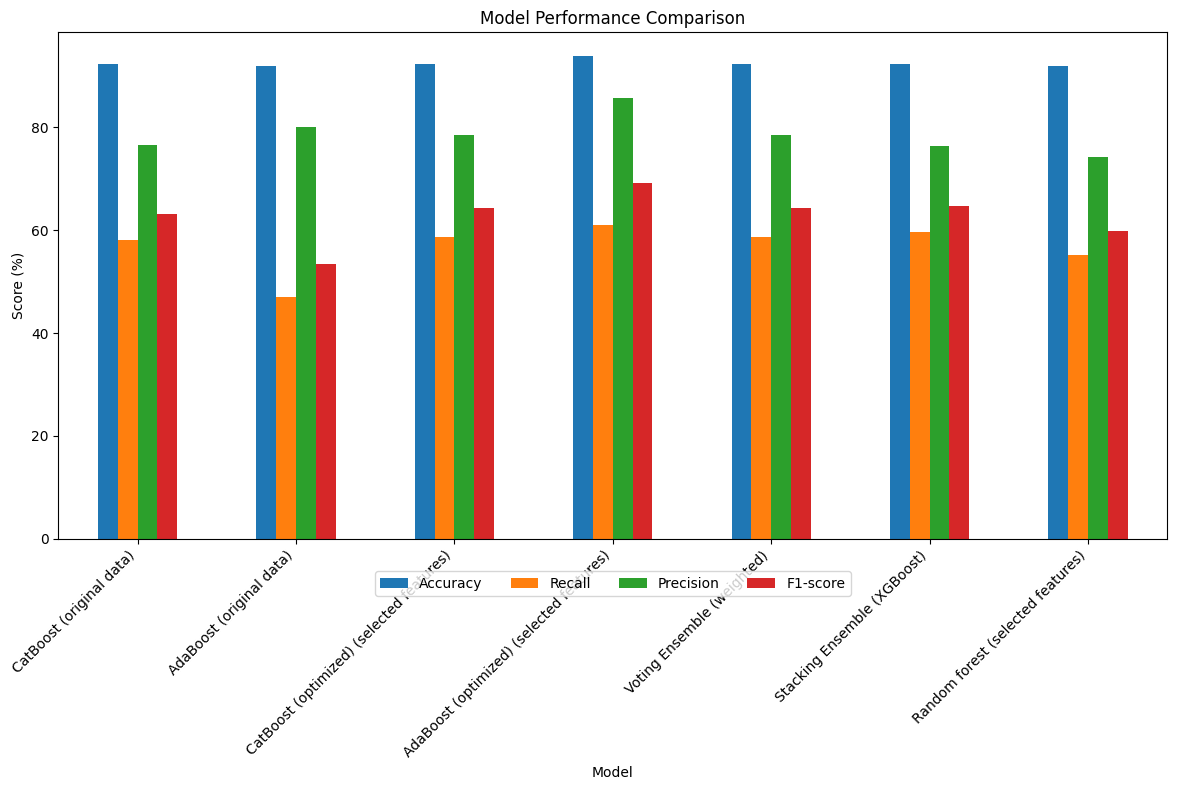

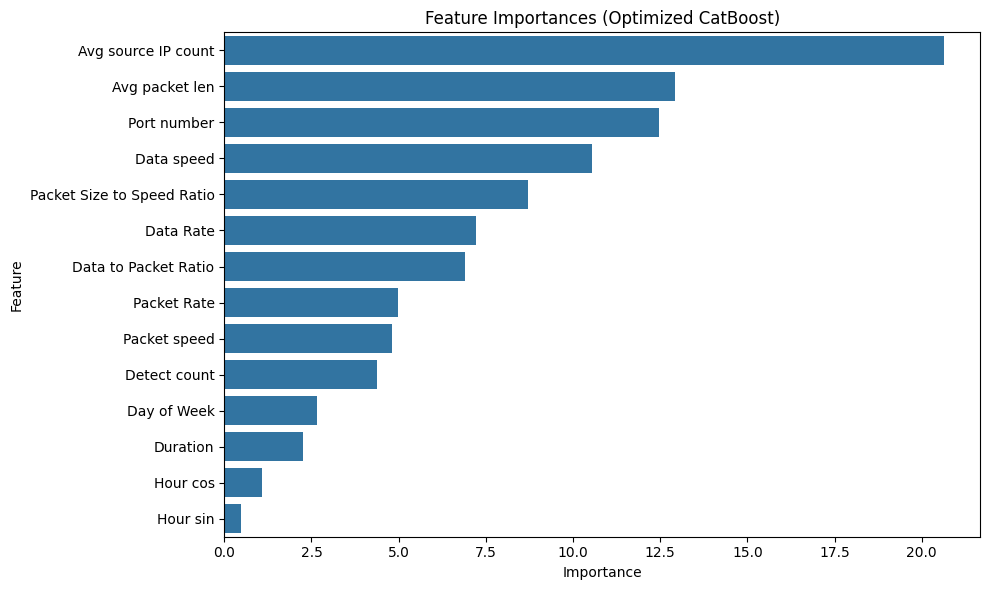


Best models saved to disk.

Completed feature selection, model optimization, and ensemble creation.


In [57]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\n=== Final Comparison ===")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.savefig('model_comparison.png')
plt.show()

# Get feature importance from the best model (CatBoost)
catboost_optimized.fit(X_train, y_train)
feature_importances = catboost_optimized.get_feature_importance()
feature_names = X_train.columns

# Create and plot feature importance DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances (Optimized CatBoost)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the best models
import joblib
joblib.dump(best_catboost, 'best_catboost_model.pkl')
joblib.dump(best_adaboost, 'best_adaboost_model.pkl')
joblib.dump(meta_learner, 'stacking_meta_learner.pkl')

print("\nBest models saved to disk.")
print("\nCompleted feature selection, model optimization, and ensemble creation.")

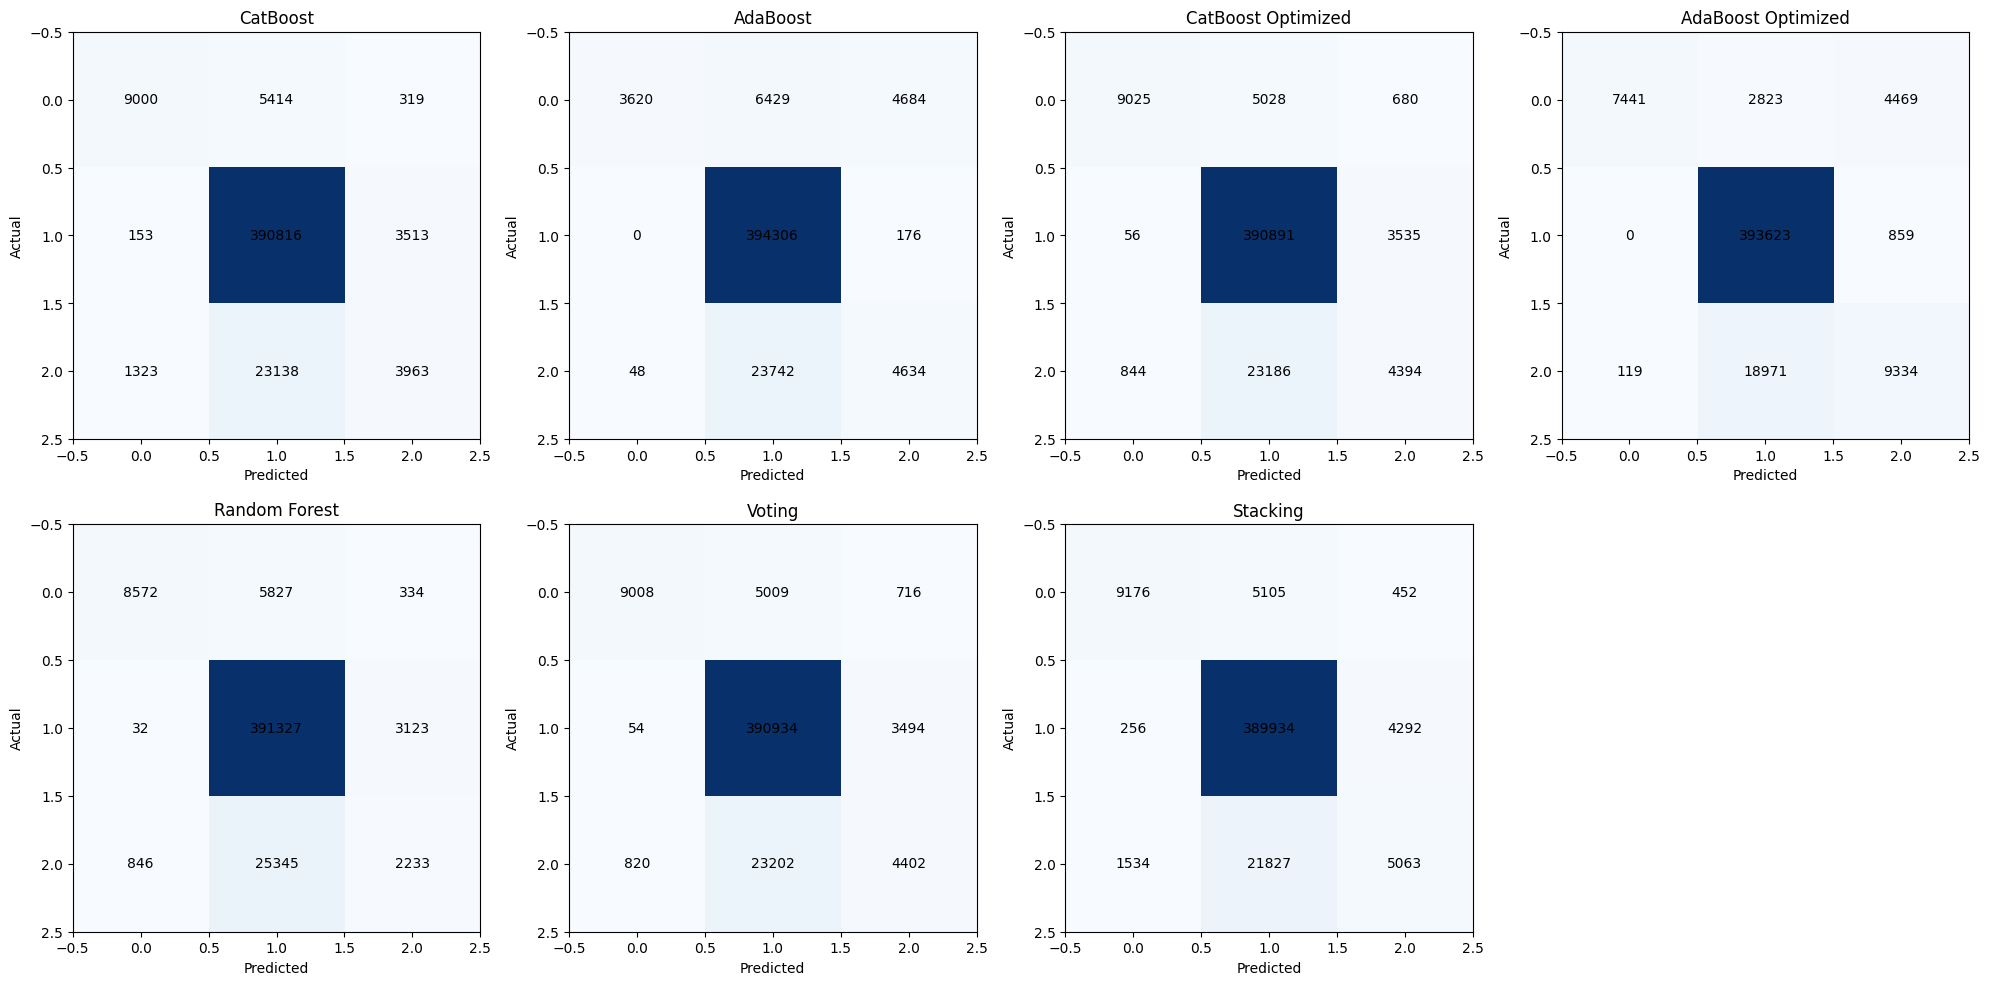

In [58]:
matrices = [
    conf_cat, conf_ada, conf_cat_opt, conf_ada_opt, 
    conf_rf, voting_conf, stacking_conf
]
titles = [
    'CatBoost', 'AdaBoost', 'CatBoost Optimized', 'AdaBoost Optimized',
    'Random Forest', 'Voting', 'Stacking'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns (7 plots + 1 empty)
axes = axes.flatten()

for i, (matrix, title) in enumerate(zip(matrices, titles)):
    im = axes[i].imshow(matrix, cmap='Blues')
    axes[i].set_title(title)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Annotate cells
    for (j, k), val in np.ndenumerate(matrix):
        axes[i].text(k, j, f'{val}', ha='center', va='center', color='black')

# Hide the last subplot (optional, since only 7 heatmaps)
if len(matrices) < len(axes):
    axes[-1].axis('off')

fig.tight_layout()
plt.show()